In [9]:
!pip install requests
!pip install beautifulsoup4 lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.4 MB/s eta 0:00:00a 0:00:01


In [10]:
import copy


class Content:

    def __init__(self, api, url=None, **kwargs):
        """
        :param api: api_key
        :param url: optional url to get the content.
        :param kwargs: optional header data
        :return: None
        """

        self.__headers = {
            "api-key": api,
            "format": "json"
        }
        self.__request_response = None

        if url is None:
            self.base_url = "https://content.guardianapis.com/search"
        else:
            self.base_url = url

        if kwargs:
            for key, value in kwargs.items():
                self.__headers[key] = value

    def __response(self, headers=None):

        """
        :param headers: optional header
        :return: returns raw response.
        """

        if headers is None:
            headers = self.__headers
        else:
            headers.update(self.__headers)

        res = requests.get(self.base_url, headers)

        return res

    def get_request_response(self, headers=None):

        """
        :param headers: optional headers
        :return: raw request response
        """

        self.__request_response = self.__response(headers)
        return self.__request_response

    def get_content_response(self, headers=None):

        """
        :param headers: optional header
        :return: json content of the response for the request
        """

        self.get_request_response(headers)
        return self.__request_response.json()

    def response_headers(self, headers=None):

        """
        :param headers: optional header
        :return: dict of header contents in the response
        """

        if self.__request_response:
            response_content = copy.deepcopy(self.__request_response.json())
        else:
            self.get_request_response(headers)
            response_content = copy.deepcopy(self.__request_response.json())

        headers_content = response_content['response']
        headers_content.pop("results")

        return headers_content

    def find_by_id(self, ids, **kwargs):

        """
        :param ids: Get the Content using its id. IDs are usually in the form
        of url/section/YYYY/month/DD/name-of-article/
        technology/2014/feb/17/flappy-bird-clones-apple-google

        :param kwargs: optional headers
        :return: dict
        """

        ids_and_options = self.__response_for_id(ids, **kwargs)
        ids_and_options.update(self.__headers)

        return self.__response(ids_and_options).json()

    @staticmethod
    def __response_for_id(ids, **kwargs):

        """
        :param ids: IDs are usually in the form
        of url/section/YYYY/month/DD/name-of-article/

        :param kwargs: optional headers
        :return: dict
        """

        headers = {}

        if ids and isinstance(ids, str):
            headers["ids"] = ids
        if kwargs:
            headers.update(kwargs)

        return headers

    @staticmethod
    def get_results(content):

        """
        :param content: response from url
        :return: list of results
        """

        if isinstance(content, dict):
            results = content["response"]["results"]
        else:
            raise TypeError("Content of type dictionary required as input.")

        return results if results else []

    def get_references_in_page(self, page_number=None):

        """
        :param page_number: optional
        :return:
        """

        head = self.response_headers()

        if page_number is None:
            content = self.get_content_response({
                "show-references": "all"
            })
            results = self.get_results(content)
            references = self.__get_references(results)
            return references
        elif page_number and page_number <= head["pages"]:
            content = self.get_content_response({
                "page": page_number,
                "show-references": "all"
            })
            results = self.get_results(content)
            references = self.__get_references(results)
            return references
        else:
            raise ValueError("Page number greater than available pages. Available pages {}."
                             .format(head["pages"]))

    @staticmethod
    def __get_references(results):

        """
        :param results: list of results
        :return: list of results
        """

        refs = [(result["id"], result["references"]) for result in results if result["references"]]

        return refs



In [11]:
class Section:

    def __init__(self, api, url=None, **kwargs):

        """
        :param api: api-key
        :param kwargs: optional headers
        :return:
        """

        self.__request_response = None
        self.__headers = {
            "api-key": api,
            "format": "json"
        }

        if not url:
            self.base_url = "https://content.guardianapis.com/sections"
        else:
            self.base_url = url

        if kwargs:
            for key, value in kwargs.items():
                self.__headers[key] = value

    def __response(self, header=None):

        """
        :param header: optional headers
        :return: raw request response
        """

        if header is None:
            header = self.__headers
        else:
            header.update(self.__headers)
        res = requests.get(self.base_url, header)

        return res

    def get_request_response(self, headers=None):

        """
        :param headers: optional headers
        :return: raw section request response
        """

        self.__request_response = self.__response(headers)
        return self.__request_response

    def get_content_response(self, headers=None):

        """
        :param headers: optional headers
        :return: dict of response
        """

        if self.__request_response is None or headers:
            self.__request_response = self.get_request_response(headers)

        return self.__request_response.json()

    @staticmethod
    def get_results(section_content):

        """
        :param section_content: dict of response received
        :return: list of results in that page
        """

        if isinstance(section_content, dict):
            results = section_content["response"]["results"]
        else:
            raise TypeError("Section content of type dictionary required as input.")

        return results if results else []

    def response_headers(self, headers=None):

        """
        :param headers: optional header
        :return: dict of header contents in the response
        """

        if self.__request_response:
            response_content = copy.deepcopy(self.__request_response.json())
        else:
            self.get_request_response(headers)
            response_content = copy.deepcopy(self.__request_response.json())

        headers_content = response_content['response']
        headers_content.pop("results")

        return headers_content


In [12]:
class Tag(Section):

    def __init__(self, api, **kwargs):

        """
        :param api: api-key
        :param kwargs: optional headers
        :return:
        """
        base_url = "https://content.guardianapis.com/tags"
        super(Tag, self).__init__(api, base_url, **kwargs)

    def get_references_in_page(self, page_number=1):

        """
        :param page_number: optional
        :return:
        """

        head = self.response_headers()

        if page_number is None:
            content = self.get_content_response({
                "show-references": "all"
            })
            results = self.get_results(content)
            references = self.__get_references(results)
            return references
        elif page_number and page_number <= head["pages"]:
            content = self.get_content_response({
                "page": page_number,
                "show-references": "all"
            })
            results = self.get_results(content)
            references = self.__get_references(results)
            return references
        else:
            raise ValueError("Page number greater than available pages. Available pages {}."
                             .format(head["pages"]))

    @staticmethod
    def __get_references(results):

        """
        :param results: list of results
        :return: list of results
        """

        refs = [(result["id"], result["references"]) for result in results if result["references"]]

        return refs


In [13]:

class Edition(Section):

    def __init__(self, api, **kwargs):

        """
        :param api: api-key
        :param kwargs: optional headers
        :return:
        """
        base_url = "https://content.guardianapis.com/editions"
        super(Edition, self).__init__(api, base_url, **kwargs)

In [44]:
from tqdm import tqdm
import time
import json
urls_by_year = {
    "2024": [],
    "2023": [],
}

API_KEY = '36dd2430-0674-4722-9e06-482dc9370694'
BASE_URL = 'https://content.guardianapis.com/search'
webUrls = set()
# headers = {"q": "world"}
# section = Section(api=API_KEY, **headers)

# # get the results
# section_content = section.get_content_response()
# print(section_content)
# results = section.get_results(section_content)

# # get different editions from the results
# editions = results[0]['editions']
# liveblogs = [edi["apiUrl"] for edi in editions][0]
num = 0
for page in tqdm(range(100,300),desc='Processing'):
    try:
        params = {
            'q': 'live blog',
            'section': 'world',
            'pageSize': '20',  
            'orderBy': "newest",
            'page': page,
        }
    
        content = Content(api=API_KEY,url=BASE_URL,**params)

        # get section response
        response = content.get_content_response()
        results = Content.get_results(response)


        for item in results:    
 
            # if item["type"] == "liveblog" :
                webUrls.add(item['webUrl'])
                
                # year = item['webPublicationDate'][:4]
                # if year in urls_by_year:
                #     urls_by_year[year].append(item['webUrl'])
                num+=1
        time.sleep(1)
    except Exception as e:
        continue
   

print(num)

# params = {
#     'api-key': API_KEY,
#     'section': 'world',
# }

# response = requests.get(BASE_URL, params=params)
# data = response.json()
# for item in response["results"]:
#     if item["type"] == "liveblog" and item["sectionId"] == "world":
#         print("Title:", item["webTitle"])
#         print("URL:", item["webUrl"])
#         print("Publication Date:", item["webPublicationDate"])
#         print("---")

# print("Filtered liveblogs:")
# print(json.dumps(liveblogs, indent=4))

Processing: 100%|██████████| 200/200 [04:08<00:00,  1.24s/it]

2000


In [45]:
print(len(webUrls))

1803


In [ ]:
#test the tag and content classes
# get the apple tags
headers = {
    "q": "apple",
    "section": "technology",
    "show-references": "all",
}
tag = Tag(api='test', **headers)

# get the results
tag_content = tag.get_content_response()
results = tag.get_results(tag_content)

# get results for specific tag
first_tag_apiUrl = results[0]["apiUrl"]

# use this api url to content
content = Content(api='test', url=first_tag_apiUrl)

# get content response
content_response = content.get_content_response()
print(content_response)


{'response': {'status': 'ok', 'userTier': 'developer', 'total': 7779, 'startIndex': 1, 'pageSize': 10, 'currentPage': 1, 'pages': 778, 'orderBy': 'newest', 'tag': {'id': 'technology/apple', 'type': 'keyword', 'sectionId': 'technology', 'sectionName': 'Technology', 'webTitle': 'Apple', 'webUrl': 'https://www.theguardian.com/technology/apple', 'apiUrl': 'https://content.guardianapis.com/technology/apple'}, 'results': [{'id': 'technology/2024/feb/22/apple-says-spotify-wants-limitless-access-to-its-tools-without-paying', 'type': 'article', 'sectionId': 'technology', 'sectionName': 'Technology', 'webPublicationDate': '2024-02-22T22:58:52Z', 'webTitle': 'Apple says Spotify wants ‘limitless’ access to its tools without paying', 'webUrl': 'https://www.theguardian.com/technology/2024/feb/22/apple-says-spotify-wants-limitless-access-to-its-tools-without-paying', 'apiUrl': 'https://content.guardianapis.com/technology/2024/feb/22/apple-says-spotify-wants-limitless-access-to-its-tools-without-payin

In [18]:
# get the sports sections
import requests
API_KEY = 'b58e3907-4865-48d9-9dd4-43e779cfd841'
headers = {"q": ""}  # q=query parameter/search parameter
section = Section(API_KEY, **headers)

# get the results
section_content = section.get_content_response()
results = section.get_results(section_content)
print(results)

# get different editions from the results
editions = results[0]['editions']
print("editions为----",editions)

# get uk/sports edition apiUrl
uk_sports = [edi["apiUrl"] for edi in editions if edi["id"] == "world"][0]

# use this api url to sports content
content = Content(API_KEY, url=uk_sports)

# get section response
content_response = content.get_content_response()
print(content_response)


[]


IndexError: list index out of range

In [ ]:
from bs4 import BeautifulSoup
import re
import json
import requests

# Define regex pattern to remove emojis
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE,
)

def crawl_and_extract_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Locate the timeline section
    key_events_div = soup.find('div', id="key-events-carousel")
    if not key_events_div:
        return None

    # Locate all article elements
    list_items = key_events_div.find_all('li', class_="dcr-awhpi0")
    article_tag = soup.find_all('article', class_="block dcr-1os4bxs")

    article_list = []
    event_time = []
    summaries = []
    key_timelines = []

    for article in article_tag:
        header_tag = article.find('header')
        header_text = header_tag.get_text(" ", strip=True).lower() if header_tag else ""
        date_tag = header_tag.find('time') if header_tag else None
        contains_summary = "summary" in header_text
        article_text = ""

        # Skip articles with summary in header or missing time
        if not contains_summary and date_tag is not None:
            for element in article.children:
                if element != header_tag and element.name is not None:
                    clean_text = emoji_pattern.sub(r'', element.get_text(" ", strip=True))
                    article_text += clean_text + " "
            article_list.append(article_text)

            if date_tag:
                datetime = date_tag['datetime']
                event_time.append(datetime)
            else:
                event_time.append("")

    # Extract summaries from the timeline section
    for li in list_items:
        time_tag = li.find('time')
        summary_div = li.find('div', class_="dcr-qkr8lv")

        if time_tag and summary_div:
            datetime = time_tag['datetime']
            summary_text = summary_div.get_text(strip=True)

            # Skip summaries that explicitly contain the word "summary"
            if "summary" not in summary_text.lower():
                summaries.append(summary_text)
                key_timelines.append(datetime)

    return {
        "document": article_list,
        "timeline": event_time,
        "summary": summaries,
        "key_timeline": key_timelines
    }


In [ ]:
def save_data_to_json(data, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
all_data = []

for url in tqdm(webUrls):
        data = crawl_and_extract_data(url)
        if data is None:
            continue
        else:
            all_data.append(data)


# Save the extracted data to a JSON file

100%|██████████| 1803/1803 [18:04<00:00,  1.66it/s]


In [48]:
save_data_to_json(all_data, 'world3.json')
print(len(all_data))

868


In [ ]:
# List of JSON files to be merged
json_files = [
    "world1.json",
    "world2.json",
    "world3.json"
]

def clean_data(data_item):
    """Remove null, empty or invalid values from a dictionary."""
    clean_item = {key: value for key, value in data_item.items() if value not in [None, 'nan', 'null', []]}
    return clean_item

def load_and_clean_json(files):
    """Load and clean multiple JSON files and combine their data."""
    all_data = []
    for file_path in files:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            # Assume each file contains a list at the root level
            for item in data:
                clean_item = clean_data(item)
                if clean_item:  # Append only if cleaned item is not empty
                    all_data.append(clean_item)
    return all_data

# Load, clean, and merge the data from multiple JSON files
merged_data = load_and_clean_json(json_files)
print(len(merged_data))

# Perform consistency checks
document_timeline_mismatch = sum(1 for item in merged_data if len(item.get('document', [])) != len(item.get('timeline', [])))
summary_key_timeline_mismatch = sum(1 for item in merged_data if len(item.get('summary', [])) != len(item.get('key_timeline', [])))

# Output the results
print(f"Mismatch in document and timeline counts: {document_timeline_mismatch}")
print(f"Mismatch in summary and key_timeline counts: {summary_key_timeline_mismatch}")

# Save the cleaned and merged data to a new JSON file
with open("world_news.json", 'w', encoding='utf-8') as outfile:
    json.dump(merged_data, outfile, ensure_ascii=False, indent=4)


1475
Mismatch in document and timeline counts: 0
Mismatch in summary and key_timeline counts: 0


In [ ]:
# Sample output of one entry
result_json = json.dumps({
    "document": article_list,
    "timeline": event_time,
    "summary": summaries,
    "key_timeline": key_timelines
}, ensure_ascii=False, indent=4)

print(result_json)


{
    "document": [
        "Top western officials have weighed in to criticise former president Donald Trump after he suggested the US might not protect NATO allies who aren’t spending enough on defence from a potential Russian invasion, Reuters reports. “Any suggestion that allies will not defend each other undermines all of our security, including that of the US, and puts American and European soldiers at increased risk,” said NATO secretary general Jens Stoltenberg in a written statement. “Any attack on NATO will be met with a united and forceful response,” he added. Polish defence minister Wladyslaw Kosiniak-Kamysz said: “NATO’s motto ‘one for all, all for one’ is a concrete commitment. Undermining the credibility of allied countries means weakening the entire NATO,” he wrote on social media platform X. “No election campaign is an excuse for playing with the security of the Alliance.” Germany’s foreign ministry posted the message ‘One for all and all for one’ with the hashtag #Str

In [53]:
print(len(merged_data))

1475


### Plot the distribution of events by year and month

['2024-01-27T15:11:02.000Z', '2024-01-27T14:48:16.000Z', '2024-01-27T14:17:37.000Z', '2024-01-27T13:53:47.000Z', '2024-01-27T13:32:02.000Z', '2024-01-27T13:01:04.000Z', '2024-01-27T11:36:51.000Z', '2024-01-27T11:08:21.000Z', '2024-01-27T10:40:14.000Z', '2024-01-27T10:14:21.000Z', '2024-01-27T09:41:56.000Z', '2024-01-27T09:10:20.000Z', '2024-01-27T08:41:19.000Z', '2024-01-27T08:26:06.000Z', '2024-01-27T08:10:18.000Z']


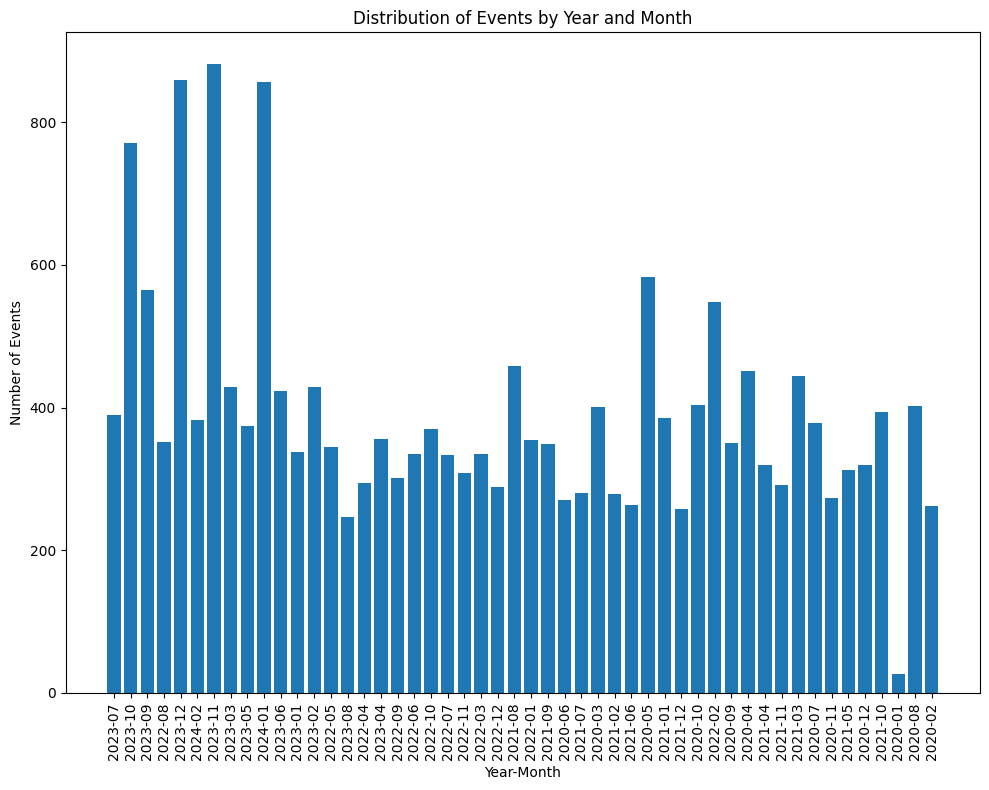

Timeline range: 2020-01-08 00:00:00 to 2024-02-22 00:00:00


In [ ]:

from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import chain



# --- Date Parsing and Visualization Functions ---

def parse_dates(timelines):
    """Extract and parse all date strings from a list of timelines."""
    dates = []
    for date_str in chain.from_iterable(timelines):
        try:
            # Assume date string is in ISO format and parse the first 10 characters
            date = datetime.strptime(date_str[:10], '%Y-%m-%d')
            dates.append(date)
        except ValueError:
            continue
    return dates

def plot_date_distribution(dates):
    """Plot the distribution of events by year and month."""
    distribution = defaultdict(int)
    for date in dates:
        year_month = (date.year, date.month)
        distribution[year_month] += 1

    labels = [f'{year}-{month:02d}' for year, month in distribution.keys()]
    counts = list(distribution.values())

    plt.figure(figsize=(10, 8))
    plt.bar(labels, counts)
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Events')
    plt.title('Distribution of Events by Year and Month')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Extract all timelines from the merged data
all_timelines = [item['timeline'] for item in merged_data if 'timeline' in item]
print(all_timelines[10])

# Parse the dates
all_dates = parse_dates(all_timelines)

# Plot the distribution of events by year and month
plot_date_distribution(all_dates)

# Determine date range
min_date = min(all_dates) if all_dates else None
max_date = max(all_dates) if all_dates else None
print(f"Timeline range: {min_date} to {max_date}")




### Plot year-wise distribution

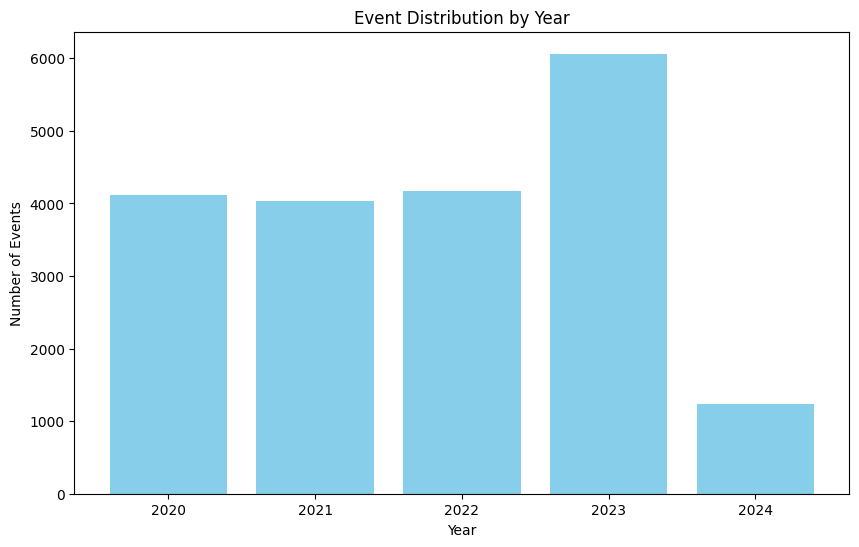

In [ ]:
from collections import defaultdict, Counter

def plot_year_distribution(dates):
    """Plot the distribution of events by year."""
    year_counts = Counter(date.year for date in dates)
    years = sorted(year_counts.keys())
    counts = [year_counts[year] for year in years]

    plt.figure(figsize=(10, 6))
    plt.bar(years, counts, color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Number of Events')
    plt.title('Event Distribution by Year')
    plt.xticks(years)
    plt.show()

# Plot year-wise distribution
plot_year_distribution(all_dates)

### plot span distribution

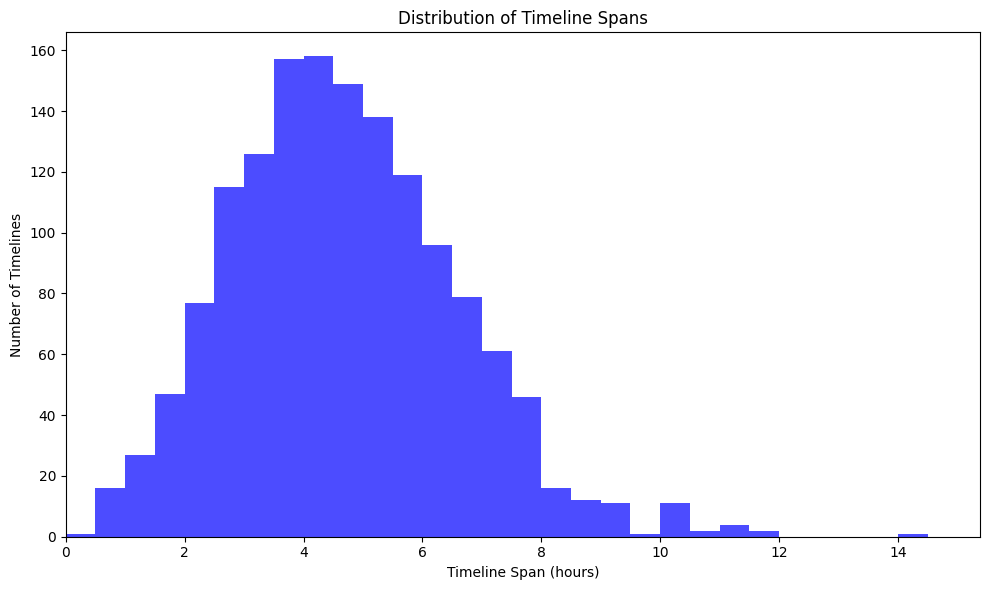

Average timeline span: 4.69 hours


In [ ]:
import numpy as np

def calculate_spans(timelines):
    """Calculate the duration (in hours) of each timeline."""
    spans = []
    for timeline in timelines:
        try:
            dates = [datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S.%fZ') for date_str in timeline]
        except ValueError:
            continue
        if dates:
            span = (max(dates) - min(dates)).total_seconds() / 3600.0
            if span < 18:
                spans.append(span)
    return spans

def plot_span_distribution(spans):
    """Plot the histogram of timeline spans (in hours)."""
    plt.figure(figsize=(10, 6))
    plt.hist(spans, bins=np.arange(0, max(spans) + 0.5, 0.5), alpha=0.7, color='blue')
    plt.xlabel('Timeline Span (hours)')
    plt.ylabel('Number of Timelines')
    plt.title('Distribution of Timeline Spans')
    plt.xticks(np.arange(0, max(spans) + 1, 2))
    plt.xlim(0, max(spans) + 1)
    plt.tight_layout()
    plt.show()

# Calculate and plot span distribution
timeline_spans = calculate_spans(all_timelines)
plot_span_distribution(timeline_spans)

# Compute average timeline span
average_span = sum(timeline_spans) / len(timeline_spans) if timeline_spans else 0
print(f"Average timeline span: {average_span:.2f} hours")



In [ ]:
# Extract year-month-day-hour from datetime
def strip_to_hour(t):
    """Return a new datetime object with precision down to the hour."""
    return datetime(t.year, t.month, t.day, t.hour)

# Example usage
now = datetime.now()
hour_only = strip_to_hour(now)

print("Current datetime:", now)
print("Stripped to hour:", hour_only)

当前时间: 2024-03-11 17:35:53.356956
转换后（到小时）: 2024-03-11 17:00:00


In [ ]:
import json
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter, defaultdict

json_file_path = 'world_news.json'  # Path to the JSON file

# Initialize variables
doc_words = 0
doc_sentences = 0
summary_words = 0
summary_sentences = 0
doc_vocab = Counter()
summary_vocab = Counter()
doc_date_counts = 0
summary_date_counts = 0
doc_sents_per_date = 0
summary_sents_per_date = defaultdict(list)
total_documents = 0
total_sentence_compression_ratio = 0
doc_date_set = set()      # Unique dates found in documents
summary_date_set = set()  # Unique dates found in summaries

date_com = 0
doc_sen = 0
doc_word = 0
summ_sen = 0
summ_word = 0

with open(json_file_path, 'r') as file:
    data = json.load(file)
    
    # Iterate through each JSON entry
    for item in data:
        if 'summary' not in item or not item['summary']:  # Skip items without a summary
            continue
        
        total_documents += 1
        
        # Process document content
        document_sentences_count = 0  # Number of sentences in current document
        document_word_count = 0       # Number of words in current document
        doc_date = 0
        
        documents = item.get('document', [])
        for doc in documents:
            words = word_tokenize(doc)
            sentences = sent_tokenize(doc)
            doc_words += len(words)
            document_word_count += len(words)
            document_sentences_count += len(sentences)
            doc_sentences += len(sentences)
            doc_vocab.update(words)

            # One timeline per document assumed
            if 'timeline' in item:
                for date in item['timeline']:
                    doc_date_counts += 1
                    doc_date += 1
                    doc_date_set.add(date)

        doc_sen += document_sentences_count / len(documents)
        doc_word += document_word_count / len(documents)

        # Process summaries
        sum_date = 0
        summary_sentences_count = 0
        summaries = item.get('summary', [])
        for summ in summaries:
            words = word_tokenize(summ)
            sentences = sent_tokenize(summ)
            summary_words += len(words)
            summary_sentences_count += len(sentences)
            summary_sentences += len(sentences)
            summary_vocab.update(words)

            # Assume one key_timeline per summary
            if 'key_timeline' in item:
                for date in item['key_timeline']:
                    summary_date_counts += 1
                    sum_date += 1
                    summary_sents_per_date[date].append(len(sentences))
                    summary_date_set.add(date)

        # Compute sentence compression ratio
        if summary_sentences_count > 0:
            total_sentence_compression_ratio += document_sentences_count / summary_sentences_count

        doc_sents_per_date += document_sentences_count / len(item['timeline'])

        # Compute document-summary date compression ratio
        date_com += doc_date / sum_date if sum_date > 0 else 0

        print(date_com)

# Compute average lengths
avg_doc_length_words = doc_words / total_documents
avg_doc_length_sentences = doc_sentences / total_documents
avg_summary_length_words = summary_words / total_documents
avg_summary_length_sentences = summary_sentences / total_documents

# Compute vocabulary sizes
doc_vocab_size = len(doc_vocab)
summary_vocab_size = len(summary_vocab)

# Compute average sentence compression ratio
avg_sentence_compression_ratio = total_sentence_compression_ratio / total_documents

# Compute average number of dates and average sentences per date
avg_dates_for_document = len(doc_date_set) / total_documents
avg_sents_dates_for_document = doc_sents_per_date / total_documents

avg_dates_for_summary = len(summary_date_set) / total_documents
avg_sents_dates_for_summary = sum(len(sents) for sents in summary_sents_per_date.values()) / summary_date_counts
avg_date_com = date_com / total_documents

# Output final statistics
print(f'Total Documents: {total_documents}')
print(f'Avg. Document Length: {avg_doc_length_words:.2f} words, {avg_doc_length_sentences:.2f} sentences')
print(f'Avg. Summary Length: {avg_summary_length_words:.2f} words, {avg_summary_length_sentences:.2f} sentences')
print(f'Document Vocabulary Size: {doc_vocab_size}')
print(f'Summary Vocabulary Size: {summary_vocab_size}')
print(f'Avg. Sentence Compression Ratio: {avg_sentence_compression_ratio:.2f}')

print(f'Avg. Dates per Document: {avg_dates_for_document:.2f}')
print(f'Avg. Sentences per Date in Document: {avg_sents_dates_for_document:.2f}')
print(f'Avg. Dates per Summary: {avg_dates_for_summary:.2f}')
print(f'Avg. Sentences per Date in Summary: {avg_sents_dates_for_summary:.2f}')
print(f'Avg. Document-to-Summary Date Compression Ratio: {avg_date_com:.2f}')


2.419753086419753
2.492238293520345
13.054738293520344
13.789432171071365
14.467632863112888
14.677702307557333
18.126681899394068
22.718518634087946
23.469629745199057
27.985254745199057
36.98525474519906
39.071674498285475
41.15809425137189
46.22059425137189
71.22059425137189
72.04704053236362
85.49148497680807
85.77847477272644
86.47291921717088
86.66195513399508
87.27930207277059
87.87101804910195
376.87101804910196
377.3154624935464
379.40188224663285
379.6306157059901
386.3906157059901
389.0312407059901
403.0937407059901
408.9916998896636
416.8316998896636
420.19281100077467
420.81015793955015
423.06015793955015
423.58908355938485
424.85470855938485
425.605819670496
426.078475920496
435.078475920496
451.078475920496
452.25208703160706
454.6718401180268
458.2397413525947
480.0175191303725
481.0175191303725
491.5800191303725
495.0289987222092
495.2593987222092
505.4993987222092
507.152459946699
508.152459946699
508.2846913516577
509.09469135165773
511.34469135165773
512.83851851215

In [ ]:
import json
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter, defaultdict

json_file_path = 'data/train.json'  # Path to the JSON file

# Initialize counters and accumulators
doc_words = 0
doc_sentences = 0
summary_words = 0
summary_sentences = 0
doc_vocab = Counter()
summary_vocab = Counter()
doc_date_counts = Counter()
summary_date_counts = Counter()
doc_sents_per_date = defaultdict(list)
summary_sents_per_date = defaultdict(list)
total_documents = 0
total_sentence_compression_ratio = 0

# Read and process the file line by line
with open(json_file_path, 'r') as file:
    for line in file:
        item = json.loads(line)

        # Skip entries without summaries
        if 'summ' not in item or not item['summ']:
            continue
        
        total_documents += 1
        
        # Process each document
        document_sentences_count = 0  # Sentence count for the current document
        documents = item.get('document', [])
        for doc in documents:
            words = word_tokenize(doc)
            sentences = sent_tokenize(doc)
            doc_words += len(words)
            document_sentences_count += len(sentences)
            doc_sentences += len(sentences)
            doc_vocab.update(words)
            
            # Each document is associated with a timeline date
            if 'timeline' in item:
                for date in item['timeline']:
                    doc_date_counts[date] += 1
                    doc_sents_per_date[date].append(len(sentences))

        # Process each summary
        summary_sentences_count = 0
        summaries = item.get('summ', [])
        for summ in summaries:
            words = word_tokenize(summ)
            sentences = sent_tokenize(summ)
            summary_words += len(words)
            summary_sentences_count += len(sentences)
            summary_sentences += len(sentences)
            summary_vocab.update(words)

        # Compute sentence compression ratio
        if summary_sentences_count > 0:  # Avoid division by zero
            total_sentence_compression_ratio += document_sentences_count / summary_sentences_count

# Compute average document and summary lengths
avg_doc_length_words = doc_words / total_documents
avg_doc_length_sentences = doc_sentences / total_documents
avg_summary_length_words = summary_words / total_documents
avg_summary_length_sentences = summary_sentences / total_documents

# Compute vocabulary sizes
doc_vocab_size = len(doc_vocab)
summary_vocab_size = len(summary_vocab)

# Compute average sentence compression ratio
avg_sentence_compression_ratio = total_sentence_compression_ratio / total_documents

# Print out statistics
print(f'Total Documents: {total_documents}')
print(f'Avg. Document Length: {avg_doc_length_words:.2f} words, {avg_doc_length_sentences:.2f} sentences')
print(f'Avg. Summary Length: {avg_summary_length_words:.2f} words, {avg_summary_length_sentences:.2f} sentences')
print(f'Document Vocabulary Size: {doc_vocab_size}')
print(f'Summary Vocabulary Size: {summary_vocab_size}')
print(f'Avg. Sentence Compression Ratio: {avg_sentence_compression_ratio:.2f}')


Total Documents: 140000
Avg. Document Length: 604.9565928571428 words, 24.06662857142857 sentences
Avg. Summary Length: 173.36508571428573 words, 7.813464285714286 sentences
Document Vocabulary Size: 1134550
Summary Vocabulary Size: 468704
avg_sentence_compression_ratio: 3.5762014064699823


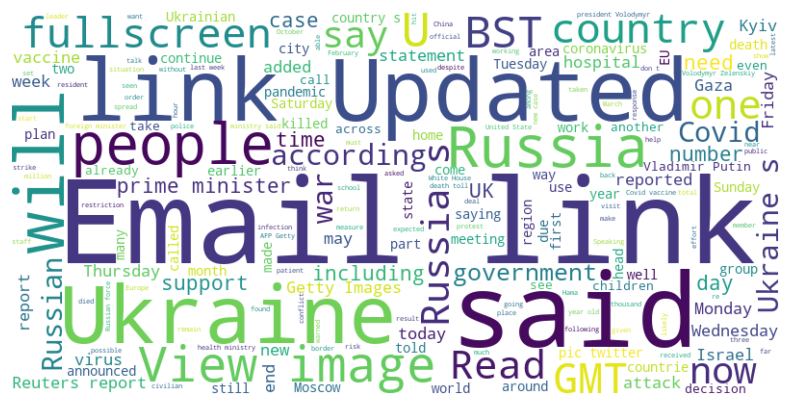

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

json_file_path = 'world_news.json'

# Concatenate all article texts into one string
all_articles_text = ""
with open(json_file_path, 'r') as file:
    data = json.load(file)
    for item in data:
        for doc in item['document']:
            all_articles_text += doc + " "

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_articles_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Save word cloud image
wordcloud.to_file('document_wordcloud.png')


ref: ['Bon Iver () is an American indie folk band founded in 2006 by singer-songwriter Justin Vernon.', "Vernon released Bon Iver's debut album, For Emma, Forever Ago, independently in July 2007.", 'The majority of that album was recorded while Vernon spent three months isolated in a cabin in northwestern Wisconsin.', 'In 2012 the band won Grammy Awards for Best New Artist and Best Alternative Music Album for their eponymous album Bon Iver.', 'They released their third album 22, A Million to critical acclaim in 2016, which was followed by their fourth album i,i in 2019.', 'The name "Bon Iver" derives from the French phrase bon hiver () ("good winter"), taken from a greeting on Northern Exposure.'] hyp1:----- ['History\nAfter the breakup of his band DeYarmond Edison, the ending of a romantic relationship, and a bout with mononucleosis hepatitis, Vernon left Raleigh, North Carolina, and moved back to Wisconsin.', " He spent the oncoming winter months at his father's cabin in Dunn County,

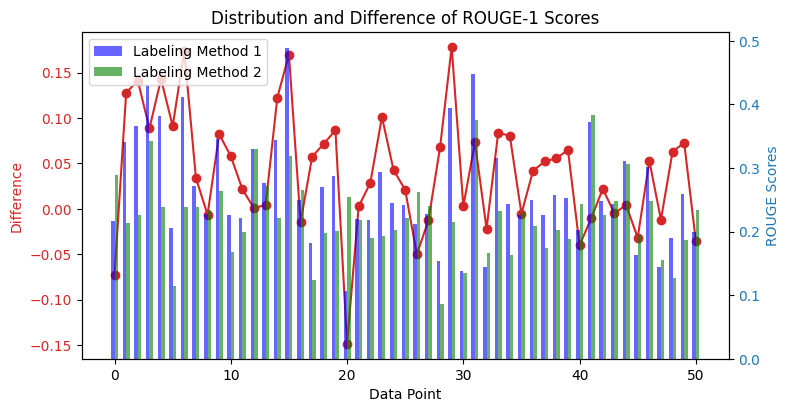

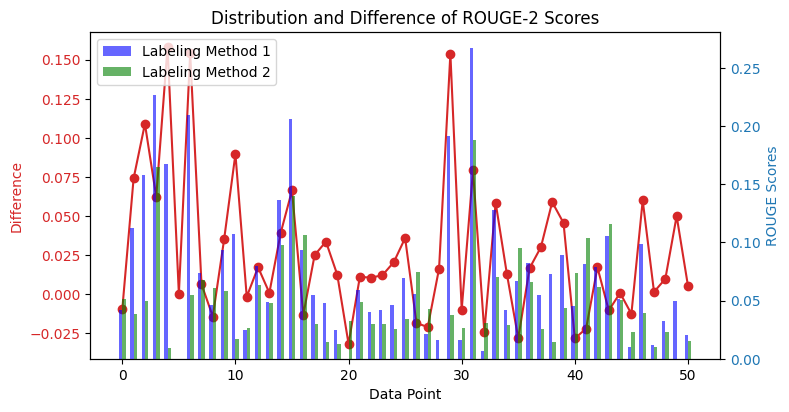

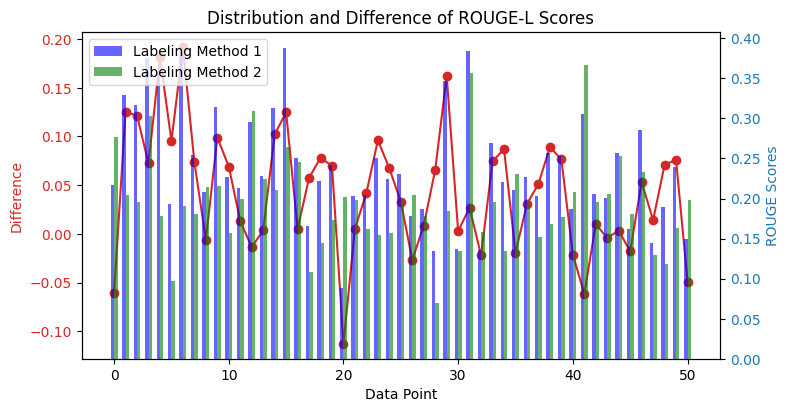

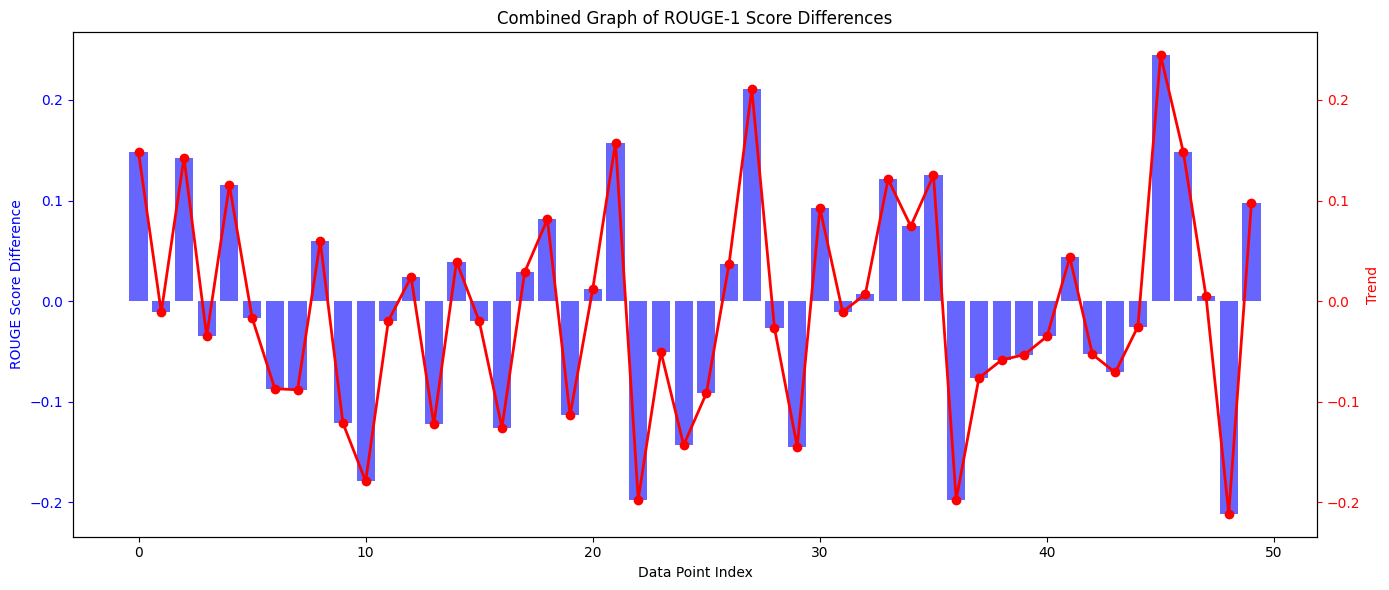

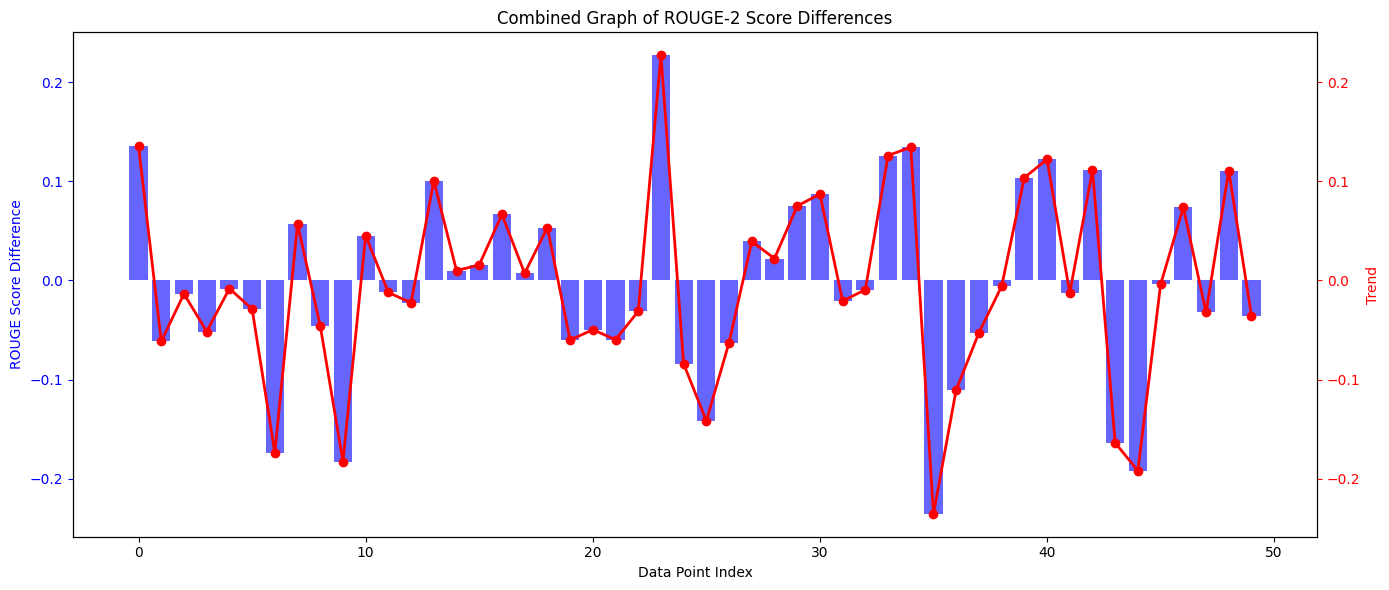

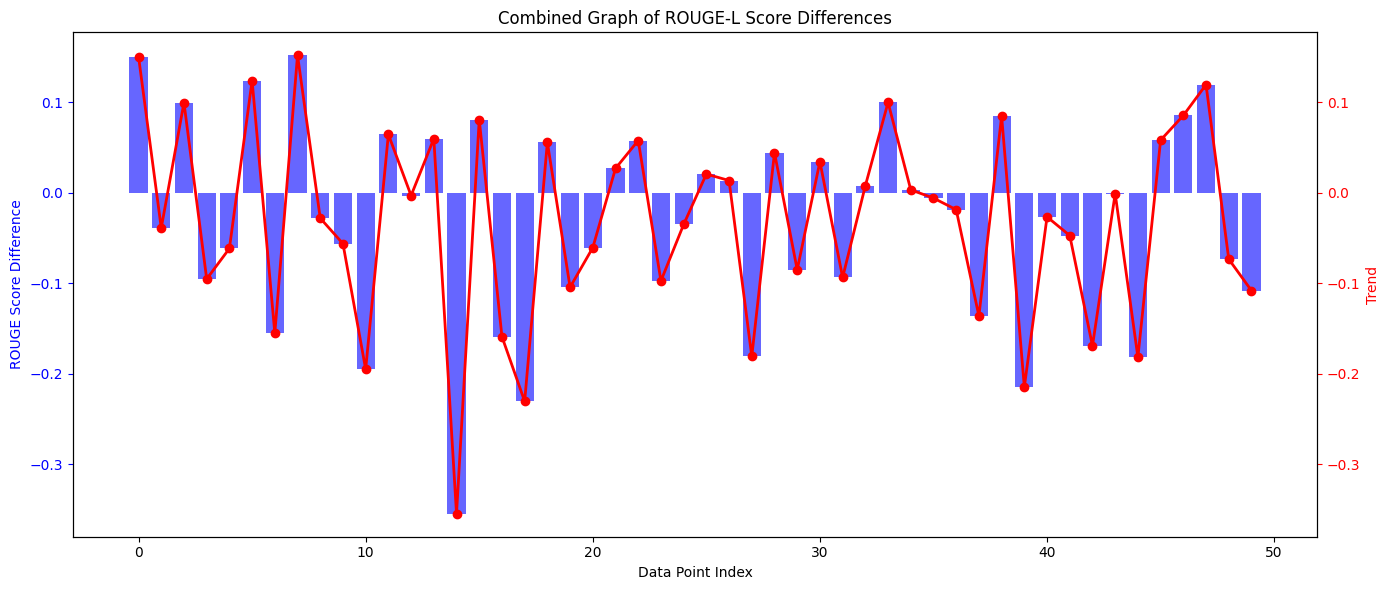

In [ ]:
import json
from rouge import Rouge
import matplotlib.pyplot as plt
import numpy as np

# This function calculates ROUGE scores using the rouge package
def calculate_rouge_with_rouge_package(ref, hyp):
    rouge = Rouge()
    scores = rouge.get_scores(" ".join(ref), " ".join(hyp), avg=True)
    return scores

# Load data and labeled results
data = [json.loads(line) for line in open('data/wiki_test_1.json', 'r')]
labeling_1 = [json.loads(line) for line in open('data/wiki_test.json', 'r')]
labeling_2 = [json.loads(line) for line in open('data/wiki_test_1.json', 'r')]

rouge_scores = {'rouge-1': [], 'rouge-2': [], 'rouge-l': []}
rouge_diff = {'rouge-1': [], 'rouge-2': [], 'rouge-l': []}

# Compute ROUGE scores and differences
for i in range(len(data)):
    ref = data[i]['summ']
    hyp_1 = [labeling_1[i]['sentences'][index] for index in labeling_1[i]['label']]
    hyp_2 = [labeling_2[i]['sentence'][index] for index in labeling_2[i]['extract_label']]
    print("ref:", ref, "hyp1:-----", hyp_1, "hyp2-----", hyp_2)

    scores_1 = calculate_rouge_with_rouge_package(ref, hyp_1)
    scores_2 = calculate_rouge_with_rouge_package(ref, hyp_2)

    for key in rouge_scores.keys():
        rouge_1_score = scores_1[key]['f']
        rouge_2_score = scores_2[key]['f']
        rouge_scores[key].append((rouge_2_score, rouge_1_score))
        rouge_diff[key].append(rouge_2_score - rouge_1_score)

print(rouge_scores)

# Compute average scores and average differences
average_scores = {}
average_diffs = {}

for key in rouge_scores.keys():
    # Compute average ROUGE scores for both methods
    method_1_avg = np.mean([score[0] for score in rouge_scores[key]])
    method_2_avg = np.mean([score[1] for score in rouge_scores[key]])
    average_scores[key] = (method_2_avg, method_1_avg)
    
    # Compute average score differences
    average_diff = np.mean(rouge_diff[key])
    average_diffs[key] = average_diff

# Print average ROUGE scores and differences
for key, (method_1_avg, method_2_avg) in average_scores.items():
    print(f"{key.upper()} - Method 1 Average Score: {method_1_avg:.4f}, Method 2 Average Score: {method_2_avg:.4f}, Average Difference: {average_diffs[key]:.4f}")

# Plot ROUGE score differences and values
def plot_rouge_differences_and_scores(scores, differences, title):
    x = np.arange(0, len(differences))
    fig, ax1 = plt.subplots(figsize=(8, 4))

    color = 'tab:red'
    ax1.set_xlabel('Data Point')
    ax1.set_ylabel('Difference', color=color)
    ax1.plot(x, differences, color=color, label='Difference', linestyle='-', marker='o')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('ROUGE Scores', color=color)
    ax2.bar(x - 0.15, [score[0] for score in scores], width=0.3, color='blue', label='Labeling Method 1', alpha=0.6)
    ax2.bar(x + 0.15, [score[1] for score in scores], width=0.3, color='green', label='Labeling Method 2', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

for key in rouge_scores.keys():
    plot_rouge_differences_and_scores(rouge_scores[key], rouge_diff[key], f'Distribution and Difference of {key.upper()} Scores')

# Simulate ROUGE score differences (for demonstration)
rouge_1_differences = np.random.normal(0, 0.1, 50)
rouge_2_differences = np.random.normal(0, 0.1, 50)
rouge_l_differences = np.random.normal(0, 0.1, 50)

# Number of data points
n = 50
index = np.arange(n)

# Plot combined bar and line chart
def plot_combined_graph(differences, title):
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Bar chart
    bars = ax1.bar(index, differences, color='b', label='ROUGE Score Difference', alpha=0.6)
    ax1.set_xlabel('Data Point Index')
    ax1.set_ylabel('ROUGE Score Difference', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_title(title)

    # Line chart (trend)
    ax2 = ax1.twinx()
    line = ax2.plot(index, differences, color='r', label='Trend', marker='o', linestyle='-', linewidth=2.0)
    ax2.set_ylabel('Trend', color='r')
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    plt.show()

plot_combined_graph(rouge_1_differences, 'Combined Graph of ROUGE-1 Score Differences')
plot_combined_graph(rouge_2_differences, 'Combined Graph of ROUGE-2 Score Differences')
plot_combined_graph(rouge_l_differences, 'Combined Graph of ROUGE-L Score Differences')
